## Random selection of sqrt(n) features

In [35]:
import pandas as pd
import numpy as np
import math

df = pd.read_csv('DATA.csv')

print(math.sqrt(len(df.axes[1])-1))
df

5.656854249492381


,STUDENT ID,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,1,2,1,2,1,3,3,9,5
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,1,3,2,2,1,5,3,9,5
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,1,3,3,2,1,4,3,9,1
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,2,1,2,1,2,1,5,3,9,4


Select **6 random features**

In [36]:
rng = [ 'Weekly sleep hours','Career aspirations',
        'Weekly study hours','Student Age',
       "Years lived in China", 'Parents marital status']

## Building a decision tree using the C4.5 method

1. Let's define entropy on the whole set $T$. Entropy determines how disordered the data set is. There are $k$ elements in the set $T$ - classes $C_j$:
$$
\text{Info}(T) = -\sum_{j=1}^k \frac{\text{freq}(C_j, T)}{|T|} \cdot \log_2 \left(\frac{\text{freq}(C_j, T)}{|T|}\right)
$$

In [37]:
import numpy as np
import pandas as pd 
import math
from collections import Counter 

def entropy(T):
    _, cnts = np.unique(T, return_counts=True)
    return -sum((cnt / len(T)) * math.log2(cnt / len(T)) for cnt in cnts)

entropy(df["GRADE"])

2.861968363284211

2. After partitioning the set $T$ by attribute X, subsets $T_1, T_2, ..., T_n$ are formed. We can calculate the conditional entropy - the spread of the resulting subset relative to the entire set $T$:

$$
\text{Info}_X (T) = \sum_{i=1}^n \frac{|T_i|}{|T|} \cdot Info(T_i)
$$

In [38]:
def conditional_entropy(T, attr): 
    total = len(T) 
    acc = 0
    for val in T[attr].unique():
        subset = T[T[attr] == val]
        acc += (len(subset) / len(T)) * entropy(subset['GRADE'])
        
    return acc

3. To correctly calculate the information gain, it should also be normalized, taking into account the uniqueness of the attribute values ​​and their impact on the tree structure. For this, the $Split \,\, information$ criterion is used:

$$
\text{split}_{\text{info}} (X) = -\sum_{i=1}^n \frac{|T_i|}{|T|} \cdot \log_2 \left(\frac{|T_i|}{|T|}\right)
$$

In [39]:
def split(T, attr): 
    total = len(T) 
    acc = 0
    for val in T[attr].unique():
        cnt = len(T[T[attr] == val])
        weight = cnt / total
        if weight > 0:
            acc -= weight * math.log2(weight)
        
    return acc

4. So, now we can calculate the information gain, normalized by the Split information criterion. Based on it, the best attribute will be selected at each level of the tree:

$$
\text{Gain\_ratio} (X) = \frac{\text{Info} (T) - \text{Info}_X (T)}{\text{split}_\text{info} (X)}
$$

In [40]:
def gain(T, attr):
    split_info_value = split(T, attr)
    if split_info_value == 0:
        return 0
    return (entropy(T['GRADE']) - conditional_entropy(T, attr)) / split_info_value

5. Building the tree

In [41]:
def most_common_class(T):
    return T['GRADE'].mode()[0]

def build_tree(T, attrs):
    if len(T['GRADE'].unique()) == 1:
        return T['GRADE'].iloc[0]
    
    if len(attrs) == 0:
        return most_common_class(T)

    gains = {attr: gain(T, attr) for attr in attrs}
    best_attribute = max(gains, key=gains.get)

    tree = {best_attribute: {}}

    for value in T[best_attribute].unique():
        subset = T[T[best_attribute] == value].drop(columns=[best_attribute])
        subtree = build_tree(subset, [attr for attr in attrs if attr != best_attribute])
        tree[best_attribute][value] = subtree

    return tree

rng_nums = ['10', '4', '20', '11', '3', '8']
decision_tree = build_tree(df, rng_nums)
print(decision_tree)


{'11': {1: {'8': {1: {'10': {1: {'20': {1: {'3': {3: {'4': {3: 1}}, 2: {'4': {3: 5, 4: 3}}, 1: 1}}, 2: {'4': {5: {'3': {2: 1}}, 3: {'3': {2: 1}}}}}}, 3: {'20': {2: {'4': {4: {'3': {2: 1}}, 3: 2, 5: 2}}, 1: {'3': {3: 6, 2: {'4': {4: 6}}}}}}, 2: {'4': {3: {'20': {1: {'3': {2: 3}}}}, 5: {'20': {1: {'3': {2: 1}}, 2: 3}}, 4: {'20': {2: {'3': {2: 5}}}}, 1: 4}}}}, 2: {'4': {3: {'3': {1: 1, 2: {'10': {2: 1, 1: {'20': {1: 1}}}}, 3: 5}}, 4: 5, 5: {'3': {2: 4, 1: 6}}}}, 3: {'4': {3: {'10': {2: {'20': {1: {'3': {2: 0}}}}, 1: 3}}, 4: {'3': {1: 1, 3: 2}}}}, 5: {'10': {1: 1, 2: 7}}, 4: {'10': {2: 3, 1: 2}}}}, 2: {'4': {3: {'20': {1: {'8': {1: {'10': {1: {'3': {3: 1, 2: 4}}, 3: 5, 2: 3}}, 2: 1, 4: 3, 3: 2}}, 2: 2}}, 5: {'3': {2: 1, 3: 3, 1: 2}}, 4: {'3': {2: {'8': {3: 2, 1: {'20': {1: {'10': {1: 5, 3: 7, 2: 7}}, 2: {'10': {1: 7, 3: 3}}}}, 2: 7}}, 1: 2}}}}, 3: {'3': {1: {'4': {3: {'10': {4: 1, 3: {'8': {3: 2, 2: 1}}, 2: 3, 1: 2}}, 4: {'10': {1: {'20': {1: {'8': {1: 0}}}}}}, 5: {'10': {2: 2, 1: 3}}}}, 2

In [42]:
def predict(tree, sample, default="Unknown"):
    if not isinstance(tree, dict):
        return tree

    attribute = next(iter(tree))
    value = sample.get(attribute)
    
    if value not in tree[attribute]:
        return default  # value not found

    subtree = tree[attribute][value]
    return predict(subtree, sample, default)

In [43]:
df['Predicted GRADE'] = predict_dataframe(decision_tree, df)
print(df[['STUDENT ID', 'Predicted GRADE']])

     STUDENT ID  Predicted GRADE
0      STUDENT1                1
1      STUDENT2                1
2      STUDENT3                1
3      STUDENT4                1
4      STUDENT5                1
..          ...              ...
140  STUDENT141                3
141  STUDENT142                5
142  STUDENT143                0
143  STUDENT144                4
144  STUDENT145                3

[145 rows x 2 columns]


## Assessment of the implemented algorithm

### Reliability (correctness)

$\text{accuracy}=\frac{\text{TP}+\text{TN}}{N}$

### Accuracy (ability to distinguish this class from others)

$\text{precision}=\frac{\text{TP}}{\text{TP}+\text{FP}}$

### Recall (ability to detect this class, sensitivity)

$\text{recall}=\frac{\text{TP}}{\text{TP}+\text{FN}}$

In [44]:
import numpy as np

df['Actual_Binary'] = df['GRADE'].apply(lambda x: 1 if x > 3 else 0)
df['Predicted_Binary'] = df['Predicted GRADE'].apply(lambda x: 1 if x > 3 else 0)

actual = df['Actual_Binary'].values
predicted = df['Predicted_Binary'].values

accuracy = np.mean(actual == predicted)

true_positive = np.sum((predicted == 1) & (actual == 1))
false_positive = np.sum((predicted == 1) & (actual == 0))
false_negative = np.sum((predicted == 0) & (actual == 1))

precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")

Accuracy: 0.89655
Precision: 0.93750
Recall: 0.78947


In [45]:
def build_tree(T, attrs):
    positive_class = T['GRADE'].apply(lambda x: 1 if x > 3 else 0)
    class_counts = positive_class.value_counts()
    total = len(positive_class)
    probabilities = {
        0: class_counts.get(0, 0) / total,
        1: class_counts.get(1, 0) / total
    }
    
    if len(class_counts) == 1 or len(attrs) == 0:
        return {'probabilities': probabilities}
    
    gains = {attr: gain(T, attr) for attr in attrs}
    best_attribute = max(gains, key=gains.get)
    
    tree = {
        'probabilities': probabilities,
        'feature': best_attribute,
        'subtrees': {}
    }
    
    for value in T[best_attribute].unique():
        subset = T[T[best_attribute] == value]
        remaining_attrs = [attr for attr in attrs if attr != best_attribute]
        subtree = build_tree(subset, remaining_attrs)
        tree['subtrees'][value] = subtree
    
    return tree

In [46]:
def predict(tree, sample, default_probabilities=None):
    if 'probabilities' in tree:
        probabilities = tree['probabilities']
    else:
        probabilities = default_probabilities or {0: 0.5, 1: 0.5}
    
    if 'feature' not in tree or tree['feature'] not in sample:
        return probabilities[1]  # Probability of positive class
    
    feature_value = sample[tree['feature']]
    subtrees = tree['subtrees']
    
    if feature_value in subtrees:
        subtree = subtrees[feature_value]
        return predict(subtree, sample, probabilities)
    else:
        # if value is not found, use probabilities of current node
        return probabilities[1]

In [47]:
def predict_dataframe(tree, df):
    predictions = []
    for _, row in df.iterrows():
        sample = row.to_dict()
        prob = predict(tree, sample)
        predictions.append(prob)
    return predictions

# Obtain predicted probabilities
# Constructing a tree
rng_nums = ['10', '15', '20', '25', '3', '8']
decision_tree = build_tree(df, rng_nums)

# Predicting Probabilities
df['Predicted_Probability'] = predict_dataframe(decision_tree, df)

# Checking the results
print(df['Predicted_Probability'])

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
140    0.555556
141    0.666667
142    0.000000
143    1.000000
144    0.000000
Name: Predicted_Probability, Length: 145, dtype: float64


In [48]:
import numpy as np

df['Actual_Binary'] = df['GRADE'].apply(lambda x: 1 if x > 3 else 0)

y_true = df['Actual_Binary'].values
y_scores = df['Predicted_Probability'].values

y_scores = np.clip(y_scores, 0, 1)

In [49]:
thresholds = np.unique(y_scores)
tprs = []
fprs = []

for thresh in thresholds:
    y_pred = (y_scores >= thresh).astype(int)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    tprs.append(tpr)
    fprs.append(fpr)

sorted_indices = np.argsort(fprs)
fprs = np.array(fprs)[sorted_indices]
tprs = np.array(tprs)[sorted_indices]

auc_roc = np.trapz(tprs, fprs)
print(f"AUC-ROC: {auc_roc:.2f}")

AUC-ROC: 0.94


In [50]:
precisions = []
recalls = []

for thresh in thresholds:
    y_pred = (y_scores >= thresh).astype(int)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 1
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

precisions.append(1)
recalls.append(0)

recalls, precisions = zip(*sorted(zip(recalls, precisions)))

auc_pr = np.trapz(precisions, recalls)
print(f"AUC-PR: {auc_pr:.2f}")

AUC-PR: 0.92


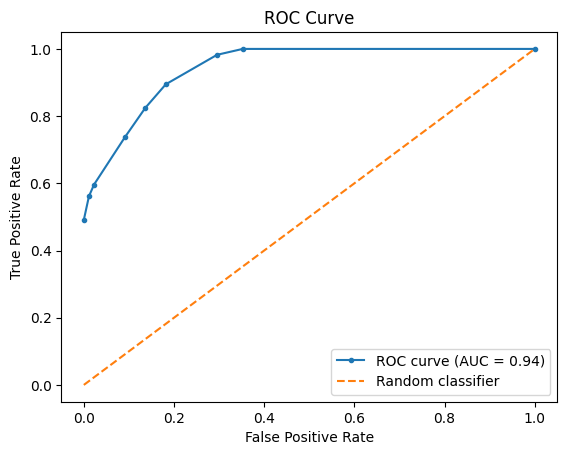

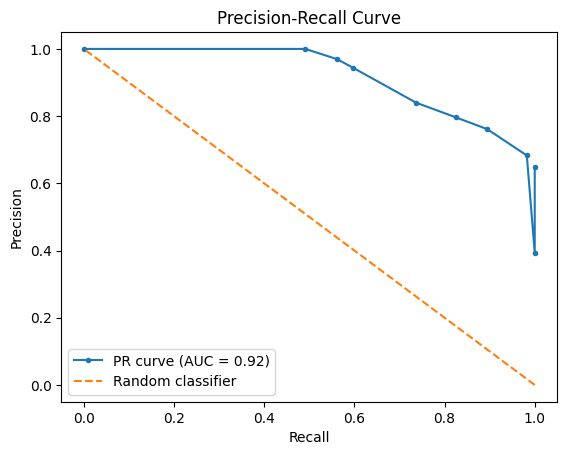

In [51]:
import matplotlib.pyplot as plt

# ROC
plt.figure()
plt.plot(fprs, tprs, marker='.', label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# PR
plt.figure()
plt.plot(recalls, precisions, marker='.', label='PR curve (AUC = {:.2f})'.format(auc_pr))
plt.plot([1, 0], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()